# Introducing Keras

Let's use Keras on the MNIST data set again, this time using a Convolutional Neural Network that's better suited for image processing. CNN's are less sensitive to where in the image the pattern is that we're looking for.

With a multi-layer perceptron, we achieved around 97% accuracy. Let's see if we can beat that.

As before we'll start by importing the stuff we need, including the new layer types we talked about:

In [1]:
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import (Dense, Conv1D, Flatten, Activation, BatchNormalization, Activation, Dropout)
from tensorflow.keras import Sequential, regularizers, optimizers
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as spio

We'll load up our raw data set exactly as before:

In [2]:
mat_files=spio.loadmat('TZP_UV_DATA_CLEAN_20201026.mat')
SPEC_CAL = mat_files['SPEC_Indy_step1_1']
Y_CAL = mat_files['HPLC_Indy_step1']
SPEC_TEST = mat_files['SPEC_Kinsale_step1_1']
Y_TEST = mat_files['HPLC_Kinsale_step1']
WL_AXIS=mat_files['WL_AXIS_Indy']
WL_AXIS=WL_AXIS.transpose();

temp_spec=np.append(SPEC_CAL,SPEC_TEST[:,1:], axis=0)
temp_y=np.append(Y_CAL,Y_TEST, axis=0)
ind=np.random.permutation(372)
SPEC_CAL=temp_spec[ind[0:300],:]
Y_CAL=temp_y[ind[0:300],:]
SPEC_TEST=temp_spec[ind[300:],:]
Y_TEST=temp_y[ind[300:],:]

SPEC_CAL = SPEC_CAL.reshape(SPEC_CAL.shape[0],SPEC_CAL.shape[1],1)
SPEC_TEST = SPEC_TEST.reshape(SPEC_TEST.shape[0],SPEC_TEST.shape[1],1)
print(SPEC_CAL.shape)
print(SPEC_TEST.shape)
print(Y_TEST.shape)
print(WL_AXIS.shape)

(300, 1778, 1)
(72, 1778, 1)
(72, 1)
(1778, 1)


We need to shape the data differently then before. Since we're treating the data as 2D images of 28x28 pixels instead of a flattened stream of 784 pixels, we need to shape it accordingly. Depending on the data format Keras is set up for, this may be 1x28x28 or 28x28x1 (the "1" indicates a single color channel, as this is just grayscale. If we were dealing with color images, it would be 3 instead of 1 since we'd have red, green, and blue color channels)

As before we need to convert our train and test labels to be categorical in one-hot format:

As a sanity check let's print out one of the training images with its label:

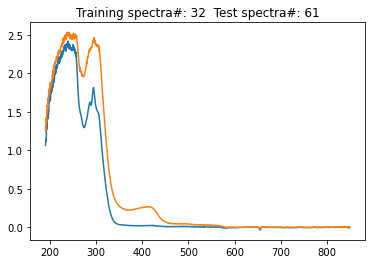

In [3]:
import matplotlib.pyplot as plt

def display_sample(num1,num2):
    #Print training and test spectra 
    fig, ax = plt.subplots()
    ax.plot(WL_AXIS,SPEC_CAL[num1,:])
    ax.plot(WL_AXIS,SPEC_TEST[num2,:])
    plt.title('Training spectra#: %d  Test spectra#: %d' % (num1, num2))
    plt.show()
    
display_sample(32,61)

Now for the meat of the problem. Setting up a convolutional neural network involves more layers. Not all of these are strictly necessary; you could run without pooling and dropout, but those extra steps help avoid overfitting and help things run faster.

We'll start with a 2D convolution of the image - it's set up to take 32 windows, or "filters", of each image, each filter being 3x3 in size.

We then run a second convolution on top of that with 64 3x3 windows - this topology is just what comes recommended within Keras's own examples. Again you want to re-use previous research whenever possible while tuning CNN's, as it is hard to do.

Next we apply a MaxPooling2D layer that takes the maximum of each 2x2 result to distill the results down into something more manageable.

A dropout filter is then applied to prevent overfitting.

Next we flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron...

... and feed that into a hidden, flat layer of 128 units.

We then apply dropout again to further prevent overfitting.

And finally, we feed that into our final 10 units where softmax is applied to choose our category of 0-9.

In [5]:
model = Sequential()
model.add(Conv1D(filters=1, kernel_size=11, strides=1, padding='same', activation='relu', input_shape=(SPEC_CAL.shape[1],1),
                 kernel_initializer='VarianceScaling', kernel_regularizer=regularizers.l2(0.1)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(32, kernel_initializer='VarianceScaling', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(1))

# Function: the MAPE metric
def mape(y_true, y_pred):
    return np.mean(np.abs(((y_true - y_pred) / y_true))) * 100


# Function: build the CNN model with different parameters like filters, l2.
#def build_model(filters=8, kernel_size=200, l2=0.0001, dropout_ratio=0.2, units=32):
#    model = Sequential()

    # construct the model structure
    # the convolutional layer with ReLu activation
#    model.add(
#        Conv1D(filters=filters,
#               kernel_size=kernel_size,
#               strides=1,
#               activation='relu',
#               padding='same',
#               input_shape=(SPEC_CAL.shape[1], 1),
#               kernel_initializer='VarianceScaling',
#               kernel_regularizer=regularizers.l2(l2)))

#    model.add(Flatten())
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
#    model.add(Dropout(dropout_ratio))
#    model.add(Dense(units, kernel_initializer='VarianceScaling', kernel_regularizer=regularizers.l2(l2)))

    # the output layer
#    model.add(Dense(1))
#    return model

Let's double check the model description:

In [29]:

# build model
#model = build_model(filters=2, kernel_size=11, l2=0.1, dropout_ratio=0.1, units=32)
optimizer = optimizers.Adam(lr=0.01)

# use earlystop to avoid overfitting and to save training time
earlystop = keras.callbacks.EarlyStopping(patience=500)

# use checkpoint to save the best model while training
if os.path.isdir("./weights/qft"):
    pass
else:
    os.mkdir("./weights/qft")
weight_path = "./weights/qft/weights_best_qft_mse_demo.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=0, save_best_only=True)

model.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 1778, 1)           12        
_________________________________________________________________
flatten_1 (Flatten)          (None, 1778)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1778)              7112      
_________________________________________________________________
activation_1 (Activation)    (None, 1778)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1778)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                56928     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

We are still doing multiple categorization, so categorical_crossentropy is still the right loss function to use. We'll use the Adam optimizer, although the example provided with Keras uses RMSProp. You might want to try both if you have time.

In [30]:
# define the loss function: 'mse'/'mape'/'mae'
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

And now we train our model... to make things go a little faster, we'll use batches of 32.

## Warning

This could take hours to run, and your computer's CPU will be maxed out during that time! Don't run the next block unless you can tie up your computer for a long time. It will print progress as each epoch is run, but each epoch can take around 20 minutes.

In [ ]:
# model training process
history = model.fit(
    x=SPEC_CAL,
    y=Y_CAL,
    batch_size=300,  # mini-batch size
    epochs=1000,
    verbose=1,
    validation_data=(SPEC_TEST, Y_TEST),
    callbacks=[earlystop, checkpoint])
del history

Epoch 1/1000
1/1 [==============================] - 0s 250ms/step - loss: 0.0682 - mse: 0.0672 - val_loss: 0.1261 - val_mse: 0.0737
Epoch 2/1000
1/1 [==============================] - 0s 90ms/step - loss: 0.1222 - mse: 0.0697 - val_loss: 0.1229 - val_mse: 0.0639
Epoch 3/1000
1/1 [==============================] - 0s 89ms/step - loss: 0.1328 - mse: 0.0738 - val_loss: 0.1172 - val_mse: 0.0652
Epoch 4/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.1192 - mse: 0.0671 - val_loss: 0.1913 - val_mse: 0.1303
Epoch 5/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.1527 - mse: 0.0917 - val_loss: 0.1832 - val_mse: 0.0667
Epoch 6/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.1839 - mse: 0.0674 - val_loss: 0.1880 - val_mse: 0.0636
Epoch 7/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.1923 - mse: 0.0679 - val_loss: 0.2182 - val_mse: 0.0633
Epoch 8/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.2231 - 

1/1 [==============================] - 0s 72ms/step - loss: 0.0695 - mse: 0.0665 - val_loss: 0.0682 - val_mse: 0.0652
Epoch 64/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.0695 - mse: 0.0665 - val_loss: 0.0678 - val_mse: 0.0648
Epoch 65/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.0694 - mse: 0.0665 - val_loss: 0.0676 - val_mse: 0.0647
Epoch 66/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0693 - mse: 0.0664 - val_loss: 0.0678 - val_mse: 0.0650
Epoch 67/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0693 - mse: 0.0665 - val_loss: 0.0680 - val_mse: 0.0652
Epoch 68/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0691 - mse: 0.0663 - val_loss: 0.0680 - val_mse: 0.0653
Epoch 69/1000
1/1 [==============================] - 0s 22ms/step - loss: 0.0691 - mse: 0.0664 - val_loss: 0.0676 - val_mse: 0.0649
Epoch 70/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.0691 - mse: 0.

Epoch 125/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0679 - mse: 0.0662 - val_loss: 0.0663 - val_mse: 0.0646
Epoch 126/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.0680 - mse: 0.0663 - val_loss: 0.0664 - val_mse: 0.0647
Epoch 127/1000
1/1 [==============================] - 0s 24ms/step - loss: 0.0677 - mse: 0.0660 - val_loss: 0.0659 - val_mse: 0.0643
Epoch 128/1000
1/1 [==============================] - 0s 111ms/step - loss: 0.0676 - mse: 0.0660 - val_loss: 0.0657 - val_mse: 0.0641
Epoch 129/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.0677 - mse: 0.0661 - val_loss: 0.0662 - val_mse: 0.0646
Epoch 130/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.0679 - mse: 0.0663 - val_loss: 0.0658 - val_mse: 0.0643
Epoch 131/1000
1/1 [==============================] - 0s 23ms/step - loss: 0.0677 - mse: 0.0662 - val_loss: 0.0661 - val_mse: 0.0645
Epoch 132/1000
1/1 [==============================] - 0s 23ms/step -

Was it worth the wait?

(10, 1778, 1)
(10, 1778)


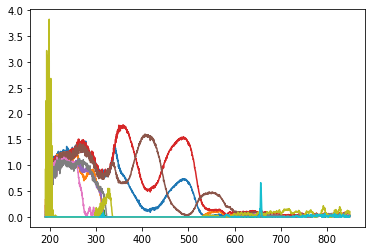

In [10]:
layers_output = [model.layers[i].output for i in range(len(model.layers))]
#print(layers_output[0].shape)

from tensorflow.keras import models

conv1D_model = models.Model(inputs=model.input, outputs=layers_output[4])
ind=np.random.permutation(300)
temp=SPEC_CAL[ind[0:10],:,:]

print(temp.shape)
conv1D_output = conv1D_model.predict(temp)
print(conv1D_output.shape)
#first_layer_activation = activations[0]
#first_layer_activation.shape

from pylab import *
#for r in range(conv1D_output.shape[2]):
for i in range(temp.shape[0]):
        #subplot(conv1D_output.shape[2],1,r+1)
    plt.plot(WL_AXIS,conv1D_output[i, :])
    

Over 99%! And that's with just 10 epochs! And from the looks of it, 4 or 5 would have been enough. It came at a significant cost in terms of computing power, but when you start distributing things over multiple computers each with multiple GPU's, that cost starts to feel less bad. If you're building something where life and death are on the line, like a self-driving car, every fraction of a percent matters.

In [25]:
model.load_weights(weight_path)
ypred_test = model.predict(SPEC_TEST)
ypred_train = model.predict(SPEC_CAL)
print(ypred_test.shape)
print(ypred_train.shape)

print("\n")
print("train")
print(r2_score(Y_CAL.ravel(), ypred_train.ravel()))
print(np.sqrt(mean_squared_error(Y_CAL.ravel(), ypred_train.ravel())))
#print(mape(Y_CAL.ravel(), ypred_train.ravel()))
#print(mean_absolute_error(Y_CAL.ravel(), ypred_train.ravel()))
#print("\n")
#print("validation")
#print(r2_score(yval.ravel(), ypred_val.ravel()))
#print(np.sqrt(mean_squared_error(yval.ravel(), ypred_val.ravel())))
#print(mape(yval.ravel(), ypred_val.ravel()))
#print(mean_absolute_error(yval.ravel(), ypred_val.ravel()))
print("\n")
print("test")
print(r2_score(Y_TEST.ravel(), ypred_test.ravel()))
print(np.sqrt(mean_squared_error(Y_TEST.ravel(), ypred_test.ravel())))
#print(mape(Y_TEST.ravel(), ypred_test.ravel()))
#print(mean_absolute_error(Y_TEST.ravel(), ypred_test.ravel()))


(72, 1)
(300, 1)


train
0.1069003149351625
0.2449498910641679


test
0.06485044477530821
0.2426941509441611


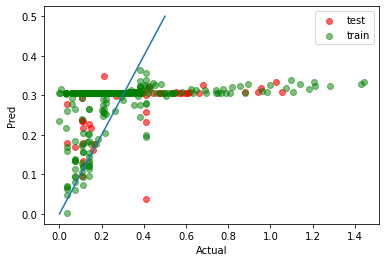

In [26]:
# plot  predicted values vs actual values
plt.scatter(Y_TEST, ypred_test, c='r', alpha=0.6, label='test')
plt.scatter(Y_CAL, ypred_train, c='g', alpha=0.5, label='train')
#plt.scatter(yval, ypred_val, c='b', alpha=0.5, label='val')
plt.plot(np.linspace(0, 0.5, 10), np.linspace(0, 0.5, 10))
plt.xlabel("Actual")
plt.ylabel("Pred")
plt.legend()
plt.show()

In [88]:
def sample_test(x):
    test_sample = SPEC_TEST[x,:].reshape(1,SPEC_TEST.shape[1],1)
    pred_label=model.predict(test_sample)
    label = Y_TEST[x]
    print('Observed value:', label)
    print('Predicted value:',pred_label)
#

sample_test(19)

Observed value: [0.74224]
Predicted value: [[0.65593386]]
